In [2]:
# импорт необходимых библиотек
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [3]:
# задание параметров
x = [-3.0 ,-1.0, 1.0, 3.0, 5.0]
y = [2.8198, 2.3562, 0.78540, 0.32175, 0.19740]
h = 2.0
X_done = -0.5

In [4]:
x = pd.Series(x)
y = pd.Series(y)
df = pd.concat([x, y], axis = 1)
Q = np.zeros(5)
df['Q'] = Q

In [5]:
# перевод значений вектора значений в тип данных float
def floating(vect):
    b = []
    for i in vect:
        b.append(float(i))
    return np.array(b)
# good working

In [6]:
x, y = floating(x), floating(y)

In [7]:
# составим СЛАУ
def create_slau(h, y):
    matrix = np.array([[0 , (2 * h) / 3, h/6],
             [h / 6, (2 * h) / 3, h/6],
             [h / 6, (2 * h) / 3, 0]])
    b = []
    for i in range(1, 4):
        b.append(((y[i + 1] - y[i]) / h) - ((y[i] - y[i - 1]) / h))
    b = np.array(b)
    return matrix, b

In [8]:
def define_vectors_A_B(matrix, b):
    A = [0]
    B = [0]
    for i in range(3):
        A.append(-matrix[i][2] / (matrix[i][1] + matrix[i][0] * A[-1]))
        B.append((b[i] - matrix[i][0] * B[-1]) / (matrix[i][1] + matrix[i][0] * A[-2]))
    A.pop(0)
    B.pop(0)
    return A, B

In [9]:
def define_qi(Q, A, B):
    for i in range(len(Q) - 2):
        Q[3 - i] = A[2 - i] * Q[3 - i + 1] + B[2 - i]
    
    c = 0
    for i in Q:
        c += 1
        print('q' + str(c), '=', i)
    return Q

In [10]:
def s_in_X(Q, X_done, x, y):
    s = []
    for i in range(1,5):
        a = ((Q[i - 1] * ((x[i] - X_done) ** 3)) / (6 * h)) + \
        ((Q[i] * ((X_done - x[i-1]) ** 3)) / (6 * h))
        b = ((y[i-1]/h) - (Q[i - 1] * (h/6))) * (x[i] - X_done)
        c = ((y[i]/h) - (Q[i] * (h/6))) * (X_done - x[i-1])
        s.append(a + b + c)
    for i in range(len(x)):
        if X_done >= x[i] and X_done <= x[i+1]:
            return s[i]

In [11]:
def graph(x, y):
    # Ввод данных
    x = x
    y = y

    cubic_interpolation_model = interp1d(x, y, kind = "cubic")

    # Рисуем график
    X_=np.linspace(x.min(), x.max(), 500)
    Y_=cubic_interpolation_model(X_)

    plt.plot(X_, Y_)
    plt.title("Кубический сплайн для функции, заданной в узлах интерполяции")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

In [19]:
print('0 - значения Х, 1 - значения У')
df

0 - значения Х, 1 - значения У


,0,1,Q
0,-3.0,2.81980,0.000000
1,-1.0,2.35620,-2.217568
2,1.0,0.78540,2.227071
3,3.0,0.32175,-0.047818
4,5.0,0.19740,0.000000


Теперь первым делом необходимо создать СЛАУ для нахождения коэффициентов q. Просто сделаем, что от нас требуется. Составим сразу матричную форму СЛАУ.

In [13]:
# первая матрица - левая часть слау (коэффициенты при неизвестных),
# вектор после нее - правая часть СЛАУ
create_slau(h, y)

(array([[0.        , 1.33333333, 0.33333333],
        [0.33333333, 1.33333333, 0.33333333],
        [0.33333333, 1.33333333, 0.        ]]),
 array([-0.5536  ,  0.553575,  0.16965 ]))

далее по формулам 
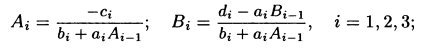
определяются **погоночные коэфы**. Их номера соответствуют номеру в списке ниже. Например, самый первый элемент - это А1, самый последний - B3.

In [14]:
print('([A1, A2, A3], [B1, B2, B3])')
define_vectors_A_B(create_slau(h, y)[0], create_slau(h, y)[1])

([A1, A2, A3], [B1, B2, B3])


([-0.25, -0.26666666666666666, -0.0],
 [-0.4151999999999999, 0.55358, -0.011954464285714249])

Теперь, наконец, найдем **коэффы q2, q3, q4**. В условии про q1 и q4 сказано, что они заведомо равны 0, это мы уже отметили. 
Остальные ищутся по формуле 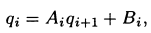 Значения приведены ниже

In [15]:
Q = define_qi(Q,
          define_vectors_A_B(create_slau(1, y)[0], create_slau(1, y)[1])[0],
          define_vectors_A_B(create_slau(1, y)[0], create_slau(1, y)[1])[1])

q1 = 0.0
q2 = -2.217567857142857
q3 = 2.2270714285714286
q4 = -0.047817857142856995
q5 = 0.0


In [16]:
df = pd.concat([pd.Series(x), pd.Series(y)], axis = 1)
df['Q'] = Q
df

,0,1,Q
0,-3.0,2.81980,0.000000
1,-1.0,2.35620,-2.217568
2,1.0,0.78540,2.227071
3,3.0,0.32175,-0.047818
4,5.0,0.19740,0.000000


Так мы теперь заполнили таблицу. Ее мы используем в следуюшем шаге.

####  Воспользуемся основной формулой, которая дает нам возможность сделать сплайн. Здесь мы просто подставляем для каждого i свои параметры x, y, q, h. Причем 
$$ h = Xi - Xi-1$$
xi и xi-1 соответсвующие таблице значения. h - const. Всего необходимо найти
$$S_1, S_2, S_3, S_4$$
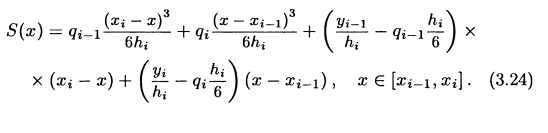
Значения для всех S нужно просто подставить из таблицы, которую мы уже составили (ячейка ниже), не производя арифметические действия.

Наконец сам график, который нам нужно было построить

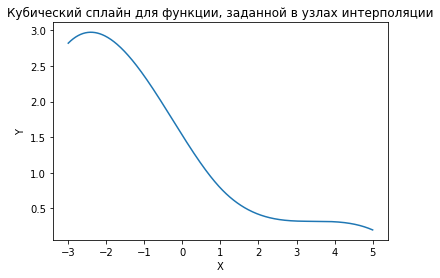

In [17]:
graph(x,y)

Теперь посчитаем значение функции У в заданной условием задачи точке Х*.

In [18]:
print('S(x*) =', s_in_X(Q, X_done, x, y))

S(x*) = 2.1006130580357145
